In [1]:
import csv, os, glob
import numpy as np
import tensorflow as tf
import features as features_lib
import tensorflow as tf
import yamnet_short

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
parent_dirs = ["D:\\datasets\\audi\\driving_resampled_16k\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\", "D:\\datasets\\audi\\driving_resampled_16k\\**\\**\\**\\"]
classes = ['0_RS3', '1_RS5_2.9', '2_RS5', '3_RS7', 
'4_RSQ3', '5_RSQ8', '6_TTRS']

filenames_all = []
for parent_dir in parent_dirs:
    filenames = glob.glob(os.path.join(parent_dir, "*.wav"))
    filenames_all.extend(filenames)
len(filenames_all)

160

In [3]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
    # AddBackgroundNoise
    # AddShortNoises
])

# @tf.function
def augment_sample(augment, wave):
    wave = augment(samples=wave, sample_rate=16000)  
    return wave

import params as yamnet_params
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(filename):
    label = tf.strings.split(filename, "D:\\datasets\\audi\\driving_resampled_16k\\Audi_")[-1]
    label = tf.strings.split(label, "_")[0]
    length = len(get_embedding(filename))
    try: 
      label = tf.repeat(label, length)
    except:
      pass
    label = tf.cast(int(label), dtype='int32')
    label = tf.one_hot(label, 6)
    return label


def get_waveform_no_label(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  waveform = tf.cast(waveform, dtype=tf.float32)
  return waveform

@tf.function
def get_embedding(filename, AUGMENT=False):
  params = yamnet_params.Params(sample_rate=16000, patch_hop_seconds=0.5)
  waveform = get_waveform_no_label(filename)
  # if AUGMENT==True:
  #   waveform = augment_sample(augment, waveform)
  waveform_padded = features_lib.pad_waveform(waveform, params)
  log_mel_spectrogram, features = features_lib.waveform_to_log_mel_spectrogram_patches(
      waveform_padded, params)
  return tf.expand_dims(features, axis=-1)
  # return log_mel_spectrogram


In [4]:
# Create a dataset of filenames
def get_dataset(filenames, augment_flag=False, training=True):
  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  # Map the filenames to the embeddings
  dataset_samples_noaugment = dataset.map(
    map_func = lambda x: tf.py_function(get_embedding, inp=[x, False], Tout=tf.float32, name=None),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  dataset_samples_augment = dataset.map(
    map_func = lambda x: tf.py_function(get_embedding, inp=[x, augment_flag], Tout=tf.float32, name=None),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  dataset_samples_combined = dataset_samples_noaugment.concatenate(dataset_samples_augment)
  dataset_labels = dataset.map(get_label)
  dataset_labels_combined = dataset_labels.concatenate(dataset_labels)

  if training==True:
    # Flatmap the embeddings to squeeze dim=0 and then zip the samples and labels
    dataset_samples_combined = dataset_samples_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))
    dataset_labels_combined = dataset_labels_combined.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

  dataset = dataset.zip((dataset_samples_combined, dataset_labels_combined))
  return dataset


In [11]:
import random
random.shuffle(filenames_all)
length = len(filenames_all)
train_dataset = get_dataset(filenames_all[:int(length*0.75)], augment_flag=True, training=True)
len(list(train_dataset))

41108

In [12]:
import datetime
i=1

AUTOTUNE = tf.data.AUTOTUNE
random.shuffle(filenames_all)

dataset = get_dataset(filenames_all, augment_flag=True, training=True).shuffle(1024)
length = len(list(dataset))
train_dataset = dataset.take(int(length*0.7)).batch(64).cache().prefetch(AUTOTUNE)
eval_dataset = dataset.skip(int(length*0.7)).take(int(length*0.2)).batch(64).cache().prefetch(AUTOTUNE)
test_dataset = dataset.skip(int(length*0.9)).batch(64).cache().prefetch(AUTOTUNE)

# print("Length of train, eval, test datasets:", len(list(train_dataset)),len(list(eval_dataset)),len(list(test_dataset)))

# Paths
training_path = "./training/{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ckp_path = training_path + "/fold{}/checkpoints/cp.ckpt".format(i+1)
log_path = training_path + "/fold{}/logs/fit".format(i+1)       
hd5_path = training_path + "/fold{}/model.hd5".format(i+1)
cfm_path = training_path + "/fold{}/confusion_matrix.png".format(i+1)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                save_weights_only=True,
                                                verbose=1)
# Create a tensorboard callback                         
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

# Declare model
Yamnet_Short = yamnet_short.Yamnet_short(6)
yamnet_model = Yamnet_Short.model()
yamnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Fit model
yamnet_model.fit(train_dataset, validation_data = eval_dataset, epochs=20, 
    verbose=1, callbacks=[cp_callback,tensorboard_callback])

# Save HD5 model from final epoch 
yamnet_model.save(hd5_path)
# new_model = tf.keras.models.load_model('my_model.h5')

# Evaluate performance of model with test fold (that it wasn't trained on)
# test_dataset = get_dataset(filenames_test, augment_flag=False, training=False).cache().prefetch(AUTOTUNE)
yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)
# print(acc)

# test_samples = test_dataset.map(lambda x,y: x)
# test_labels = test_dataset.map(lambda x,y: y[0])

# # Get y_preds = predictions made by model
# y_preds = []
# for x in test_samples:
#     y_pred = tf.argmax(tf.math.reduce_sum(yamnet_model.predict(x), axis=0))
#     y_preds.append(y_pred)

# y_preds = np.array(y_preds)

# # Get y_true = actual labels
# def get_numpy(a_list):
#     for b in a_list:
#         yield b.numpy()

# y_true = np.array([b for b in get_numpy(list(test_labels))])
# accuracy = accuracy_score(y_true, y_preds)
# print("Testing accuracy: ", accuracy)
# cm = ConfusionMatrixDisplay.from_predictions(y_true, y_preds)
# cm.figure_.savefig(cfm_path,dpi=500)


Epoch 1/20
    155/Unknown - 18s 75ms/step - loss: 1.4695 - accuracy: 0.4819

KeyboardInterrupt: 

In [7]:
yamnet_model.load_weights(ckp_path)
loss, acc = yamnet_model.evaluate(test_dataset, verbose=2)
# print(acc)

82/82 - 1s - loss: 0.1394 - accuracy: 0.9566 - 1s/epoch - 15ms/step


Testing accuracy:  0.9722100895392007


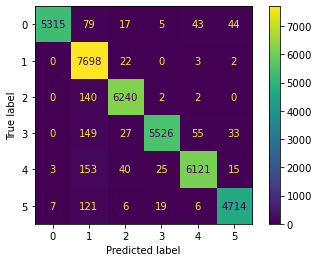

In [8]:
test_samples = train_dataset.map(lambda x,y: x)
test_labels = train_dataset.map(lambda x,y: y)

# Get y_preds = predictions made by model
y_preds,y_trues = [],[]
for x_test, y_true in zip(test_samples, test_labels):
    y_pred = np.argmax(yamnet_model.predict(x_test), axis=1)
    y_true = np.argmax(y_true, axis=1)
    y_preds.extend(y_pred)
    y_trues.extend(y_true)
y_trues = np.array(y_trues)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_trues, y_preds)
print("Testing accuracy: ", accuracy)
cm = ConfusionMatrixDisplay.from_predictions(y_trues, y_preds)
cm.figure_.savefig(cfm_path,dpi=500)

In [9]:
test_samples = train_dataset.map(lambda x,y: x)
test_labels = train_dataset.map(lambda x,y: y)
for i in test_labels.unbatch():
    print(np.argmax(i))

2
0
3
3
1
0
1
0
1
3
1
4
0
0
1
1
0
0
4
4
0
1
0
0
0
2
2
2
0
3
0
2
3
3
0
1
0
4
0
2
3
0
4
0
0
4
1
1
1
0
0
2
0
0
2
1
4
1
0
0
0
0
0
2
4
0
4
4
0
4
1
0
0
2
1
4
0
0
0
0
0
4
4
0
2
0
4
0
0
4
4
2
2
0
0
2
3
3
3
4
2
4
0
0
4
1
0
2
0
0
4
3
4
0
0
0
2
0
0
2
0
4
4
1
4
3
0
1
0
2
4
0
1
4
4
3
0
2
0
4
4
4
0
4
4
0
3
0
1
1
0
0
0
0
0
2
0
4
3
4
2
2
3
4
0
4
0
5
0
4
1
0
0
4
0
4
2
4
1
1
4
0
1
2
3
0
3
3
3
3
1
1
0
0
2
0
4
1
3
0
4
0
1
4
4
4
1
3
2
5
0
0
3
1
3
2
3
1
0
0
3
0
2
0
0
4
0
0
2
0
4
0
0
4
4
2
3
0
4
4
3
4
4
3
2
0
1
3
0
1
1
4
0
4
4
4
2
3
2
2
4
0
3
4
2
3
4
4
5
3
3
4
0
1
1
4
4
0
4
0
3
0
3
4
0
0
3
0
2
0
3
3
3
4
0
3
4
3
4
2
4
4
1
0
4
0
0
0
2
2
1
3
0
0
0
0
3
0
3
4
1
4
3
4
2
0
3
0
3
0
5
4
2
2
3
0
0
0
4
3
3
0
1
0
4
0
3
3
4
0
0
1
1
3
2
1
3
0
0
3
3
2
3
0
0
0
3
0
4
0
0
3
4
3
0
0
3
0
3
0
0
2
3
1
3
4
2
3
3
0
4
4
0
4
0
3
4
3
3
4
0
2
0
3
4
4
0
1
0
3
1
2
4
2
3
0
0
0
3
0
1
0
0
4
3
0
3
3
0
3
4
4
2
2
0
0
1
3
0
2
3
3
3
0
4
3
1
1
3
0
1
3
2
3
3
1
3
3
1
0
3
0
0
3
3
4
0
0
3
0
0
4
0
3
0
3
4
3
3
2
3
0
3
2
3
3
2
3
3
3
1
0
0
4
2
0
0
3
4
3


In [10]:
for x,y in zip(test_samples.take(1), test_labels.take(1)):
    print(x.shape,y.shape)
    A = model.predict(x)
    plt.imshow(x)
    plt.show()


(64, 96, 64, 1) (64, 6)


NameError: name 'model' is not defined

In [ ]:
model.evaluate(test_dataset, verbose=2)

86/86 - 16s - loss: 1.3898 - accuracy: 0.0321 - 16s/epoch - 189ms/step


[1.3898358345031738, 0.03205828741192818]

In [ ]:
@tf.function
def check_y(y):
    y = np.argmax(y, axis=1)
    if y.shape == None:
        state = False
    else:
        if y>=0 and y<=6:
            state = True
        else: state = False
    return state
    
# print(len(list(train_dataset.unbatch())))
print(len(list(train_dataset.unbatch().filter(lambda x,y: tf.argmax(y, axis=1)==1))))

InvalidArgumentError: Expected dimension in the range [-1, 1), but got 1
	 [[{{node ArgMax}}]] [Op:IteratorGetNext]

In [ ]:
import matplotlib.pyplot as plt
for x, y in train_dataset.unbatch().filter(lambda x,y: check_y(y)).take(10):
    plt.imshow(x)
    plt.show()

NotImplementedError: in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_31704\2517211971.py", line 2, in None  *
        lambda x,y: check_y(y)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_31704\872261716.py", line 3, in check_y  *
        y = np.argmax(y, axis=1)
    File "<__array_function__ internals>", line 5, in argmax  **
        
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 1195, in argmax
        return _wrapfunc(a, 'argmax', axis=axis, out=out)
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 54, in _wrapfunc
        return _wrapit(obj, method, *args, **kwds)
    File "C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\core\fromnumeric.py", line 43, in _wrapit
        result = getattr(asarray(obj), method)(*args, **kwds)

    NotImplementedError: Cannot convert a symbolic Tensor (y:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
